In [81]:
from exif import Image
from parse import parse
import numpy as np


In [82]:
# Step 1: Convert yaw, pitch, distance to ENU vector
def spherical_to_enu(yaw_deg, pitch_deg, distance_m):
    print(yaw_deg)
    yaw_rad = np.radians(yaw_deg)
    pitch_rad = np.radians(pitch_deg)
    x = distance_m * np.cos(pitch_rad) * np.sin(yaw_rad)  # East
    y = distance_m * np.cos(pitch_rad) * np.cos(yaw_rad)  # North
    z = distance_m * np.sin(pitch_rad)                    # Up
    return np.array([x, y, z])

# Step 2: Convert geodetic to ECEF
def geodetic_to_ecef(lat_deg, lon_deg, alt_m):
    a = 6378137.0
    e2 = 6.69437999014e-3
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    N = a / np.sqrt(1 - e2 * np.sin(lat)**2)
    x = (N + alt_m) * np.cos(lat) * np.cos(lon)
    y = (N + alt_m) * np.cos(lat) * np.sin(lon)
    z = (N * (1 - e2) + alt_m) * np.sin(lat)
    return np.array([x, y, z])

# Step 3: Convert ENU to ECEF
def enu_to_ecef(enu, lat_deg, lon_deg):
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    R = np.array([
        [-np.sin(lon),              np.cos(lon),              0],
        [-np.sin(lat)*np.cos(lon), -np.sin(lat)*np.sin(lon), np.cos(lat)],
        [np.cos(lat)*np.cos(lon),   np.cos(lat)*np.sin(lon), np.sin(lat)]
    ])
    return R.T @ enu

# Step 5: Convert ECEF to Geodetic
def ecef_to_geodetic(x, y, z):
    a = 6378137.0
    e2 = 6.69437999014e-3
    b = a * (1 - e2)**0.5
    ep = ((a**2 - b**2) / b**2)**0.5
    p = (x**2 + y**2)**0.5
    th = np.arctan2(a * z, b * p)
    lon = np.arctan2(y, x)
    lat = np.arctan2(z + ep**2 * b * np.sin(th)**3, p - e2 * a * np.cos(th)**3)
    N = a / np.sqrt(1 - e2 * np.sin(lat)**2)
    alt = p / np.cos(lat) - N
    return np.degrees(lat), np.degrees(lon), alt

# -----------------------
# Example Input
cam_lat = 37.7749       # Camera latitude
cam_lon = -122.4194     # Camera longitude
cam_alt = 10            # Camera altitude (m)
yaw = 45                # Yaw to object in degrees (0° = North, 90° = East)
pitch = 0               # Pitch to object in degrees (0° = horizontal)
distance = 100          # Distance to object in meters

def Spherical2Global(cam_lat,cam_lon,cam_alt,yaw,pitch,distance,verbose = True):

    # Step 1: Relative position in ENU
    enu_vec = spherical_to_enu(yaw, pitch, distance)
    if verbose: print("Step 1 - ENU Vector (camera-relative):", enu_vec)
    # Step 2: Camera position in ECEF
    cam_ecef = geodetic_to_ecef(cam_lat, cam_lon, cam_alt)
    if verbose: print("Step 2 - Camera ECEF Coordinates:", cam_ecef)
    # Step 3: ENU vector rotated to ECEF frame
    ecef_vec = enu_to_ecef(enu_vec, cam_lat, cam_lon)
    if verbose: print("Step 3 - Object ECEF Displacement:", ecef_vec)
    # Step 4: Final ECEF position of object
    obj_ecef = cam_ecef + ecef_vec
    if verbose: print("Step 4 - Object ECEF Coordinates:", obj_ecef)
    # Step 5: Convert ECEF back to latitude, longitude, altitude
    obj_lat, obj_lon, obj_alt = ecef_to_geodetic(*obj_ecef)
    if verbose: print("Step 5 - Object Geographic Coordinates:")

    if verbose: 
        print(f"Latitude:  {obj_lat:.8f}")
        print(f"Longitude: {obj_lon:.8f}")
        print(f"Altitude:  {obj_alt:.2f} m")

    return (obj_lat,obj_lon,obj_alt)


In [83]:
def DMS2DD(dms_tuple):
    deg,min,sec = dms_tuple
    dd = deg+(min/60)+(sec/3600)
    return dd

In [90]:
with open('IMG_20250609_072219Z.jpg', 'rb') as image_file:
    my_image = Image(image_file)

print("Image includes EXIF tags:",my_image.has_exif)
# dir(my_image)  # Print all available tags

Image includes EXIF tags: True


In [91]:
print("Orientation  :",my_image.user_comment)
print("GPS Lat (DMS/DD):",my_image.gps_latitude,'/',DMS2DD(my_image.gps_latitude))
print("GPS Lon (DMS/DD):",my_image.gps_longitude,'/',DMS2DD(my_image.gps_longitude))
print("GPS Alt (m)  :",my_image.gps_altitude)

Y,P,R = parse('Yaw:{:f},Pitch:{:f},Roll:{:f}\x00',my_image.user_comment)

Lat   = DMS2DD(my_image.gps_latitude)
Lon   = DMS2DD(my_image.gps_longitude)
Alt   = my_image.gps_altitude

obj_lat,obj_lon,obj_alt = Spherical2Global(Lat,Lon,Alt,Y,P,200,verbose=False)

Orientation  : Yaw:242.34624,Pitch:-1.1177090282324769,Roll:0.11405035972779842 
GPS Lat (DMS/DD): (37.0, 24.0, 56.9124) / 37.415808999999996
GPS Lon (DMS/DD): (23.0, 21.0, 4.9319) / 23.351369972222223
GPS Alt (m)  : 36.737
242.34624


242.34624
Step 1 - ENU Vector (camera-relative): [-221.39998729 -116.00975925   -4.87661634]
Step 2 - Camera ECEF Coordinates: [4656666.66784111 2010428.83739926 3854169.1158613 ]
Step 3 - Object ECEF Displacement: [ 148.91352264 -176.86182151  -95.10341144]
Step 4 - Object ECEF Coordinates: [4656815.58136375 2010251.97557776 3854074.01244985]
Step 5 - Object Geographic Coordinates:
Latitude:  37.41476371
Longitude: 23.34886902
Altitude:  31.87 m


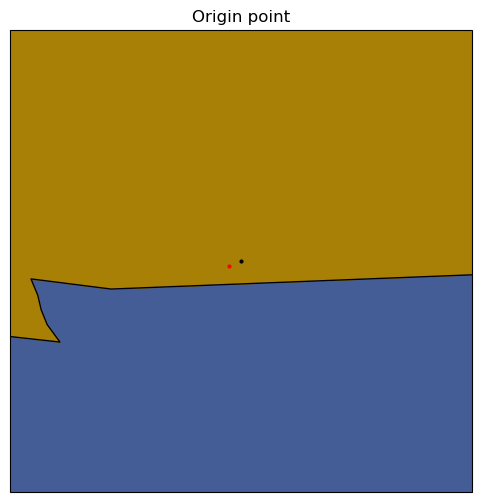

In [93]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

off = 0.05

cam_lat,cam_lon = (Lat,Lon)
obj_lat,obj_lon,obj_alt = Spherical2Global(Lat,Lon,Alt,Y,P,250,verbose=True)

# Set up map projection and figure
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
# Add ocean with blue color
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m', edgecolor='face', facecolor="#455d96")
ax.add_feature(ocean)
# Add land with green color
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor="#a88006")
ax.add_feature(land)
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)

# Set window on map to plot upon
ax.set_extent([Lon-off, Lon+off, Lat-off, Lat+off], crs=ccrs.PlateCarree())  # USA extent

# Plot points

ax.plot(cam_lon, cam_lat, marker='o', color='black', label = 'camera', markersize=2, transform=ccrs.PlateCarree())
ax.plot(obj_lon, obj_lat, marker='o', color='red', label = 'object', markersize=2, transform=ccrs.PlateCarree())

plt.title("Origin point")
plt.show()



In [75]:
obj_lat,obj_lon,obj_alt = Spherical2Global(Lat,Lon,Alt,Y,P,200,verbose=False)

242.34624


In [78]:
obj_alt

32.838840421289206